<br>

<div style = "text-align : center">
    <center><font size = 13> Bootstrapping을 통한 모수에 대한 불확실성 측정 </font></center>
    <img src = "./img/Bootstrap.png" , width = 1000px> 
</div>


<br><br>

<div  style="text-align: right">
    <font size = 7 > 19/05/03 이성령 </font>
</div>

# Library Load

In [1]:
import matplotlib.pyplot as plt
import numpy as np , pandas as pd
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

from IPython.core.display import display, HTML
from pymc3 import  *
import pymc3 as pm
display(HTML("<style>.container { width:95% !important; }</style>"))
np.random.seed(1234)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# $y = x + \epsilon$
* $\epsilon \sim N(0,0.1^2)$

In [2]:
n = 100
x = np.random.uniform(low = -1 , high = 1 , size = n)[:,np.newaxis]
eps = np.random.normal(loc = 0 , scale = 0.1 , size = n)[:,np.newaxis]
y = x + eps

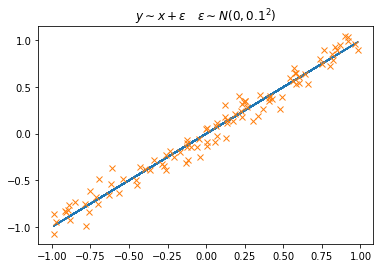

In [3]:
plt.plot(x,y-eps)
plt.plot(x,y,"x") ; 
plt.title(r"$y \sim x + \epsilon \quad \epsilon \sim N(0,0.1^2)$")
plt.show()

<br>
<center>
    <font size = 7>
        Regression Analysis
</font>
</center>

<br>
    
| parameter | coef | std |
| --- | --- | --- |
| $\beta_0$ | 0.0018 | 0.01 |
| $\beta_1$ | 0.9941 | 0.018 |



In [4]:
x2   = sm.add_constant(x)
est  = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     3199.
Date:                Sun, 28 Apr 2019   Prob (F-statistic):           1.24e-76
Time:                        17:24:46   Log-Likelihood:                 92.141
No. Observations:                 100   AIC:                            -180.3
Df Residuals:                      98   BIC:                            -175.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.010      0.181      0.8

In [5]:
beta_0_std , beta_1_std = est2.bse
beta_0 , beta_1 = est2.params

In [6]:
Data = np.concatenate((x,y), axis = 1)

In [7]:
idx = np.random.choice(np.arange(len(x)) , size = 100 , replace = True)

# Bootstrap 1000번

## 데이터를 중복을 허용한 Sampling을 통해 `모수에 대한 불확실성`를 측정할 수 있는 좋은 방법론

In [8]:
Beta0 , Beta1 = [] , []
Beta0_std , Beta1_std = [] , []
for i in np.arange(1000) :
    idx = np.random.choice(np.arange(len(x)) , size = 100 , replace = True)
    xx = x[idx]
    yy = y[idx]
    x2   = sm.add_constant(xx)
    est  = sm.OLS(yy, x2).fit()
    beta_0_std , beta_1_std = est.bse
    beta_0 , beta_1 = est.params
    Beta0.append(beta_0)
    Beta1.append(beta_1)
    Beta0_std.append(beta_0_std)
    Beta1_std.append(beta_1_std)

    

In [9]:
Output = np.concatenate((np.array(Beta0)[:,np.newaxis] ,
                         np.array(Beta1)[:,np.newaxis] ,
                         np.array(Beta0_std)[:,np.newaxis] , 
                         np.array(Beta1_std)[:,np.newaxis]),
                        axis = 1)
Output = pd.DataFrame(Output)
Output.columns = ["Beta0 Coef", "Beta1 Coef", "Beta0 Std Err" , "Beta1 Std Err"]

# Visualization

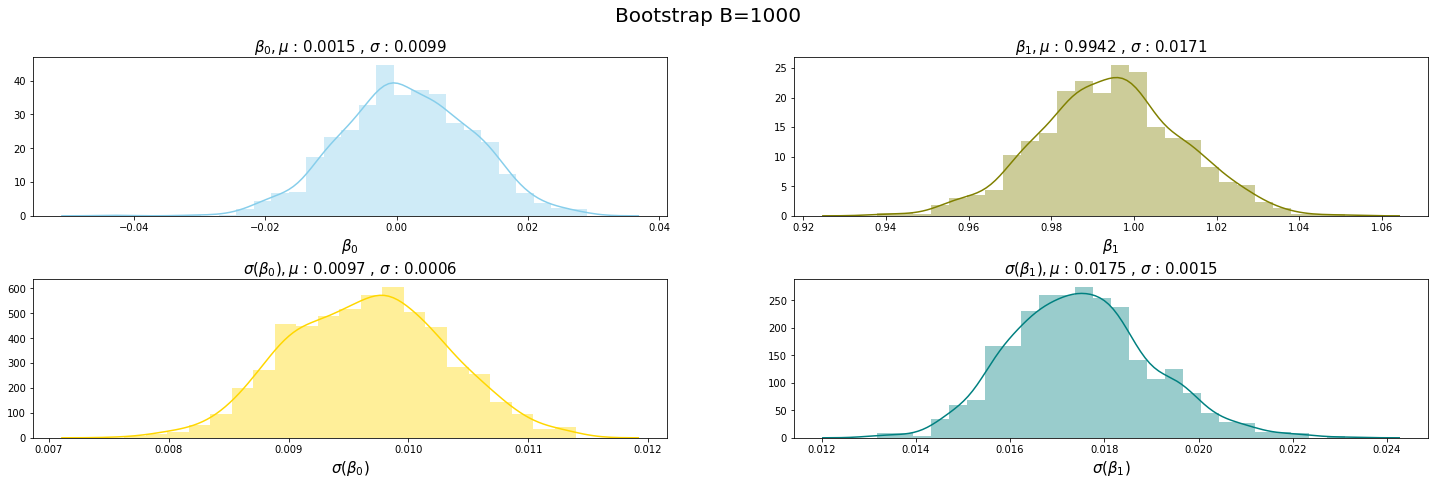

In [10]:

f, axes = plt.subplots(2, 2, figsize=(25, 7))
plt.subplots_adjust(hspace = 0.4)
sns.distplot( Output["Beta0 Coef"] , color="skyblue", ax=axes[0, 0])
axes[0,0].set_title(r"$\beta_0 , \mu$ : {:.4f} , $\sigma$ : {:.4f}".format(np.mean(Output["Beta0 Coef"]), np.std(Output["Beta0 Coef"])), fontsize = 15)
axes[0,0].set_xlabel(r"$\beta_0$" , fontsize = 15)
sns.distplot( Output["Beta1 Coef"] , color="olive", ax=axes[0, 1])
axes[0,1].set_title(r"$\beta_1 , \mu$ : {:.4f} , $\sigma$ : {:.4f}".format(np.mean(Output["Beta1 Coef"]), np.std(Output["Beta1 Coef"])), fontsize = 15)
axes[0,1].set_xlabel(r"$\beta_1$" , fontsize = 15)
sns.distplot( Output["Beta0 Std Err"] , color="gold", ax=axes[1, 0])
axes[1,0].set_title(r"$\sigma(\beta_0) , \mu$ : {:.4f} , $\sigma$ : {:.4f}".format(np.mean(Output["Beta0 Std Err"]), np.std(Output["Beta0 Std Err"])), fontsize = 15)
axes[1,0].set_xlabel(r"$\sigma(\beta_0)$" , fontsize = 15)
sns.distplot( Output["Beta1 Std Err"] , color="teal", ax=axes[1, 1])
axes[1,1].set_title(r"$\sigma(\beta_1) , \mu$ : {:.4f} , $\sigma$ : {:.4f}".format(np.mean(Output["Beta1 Std Err"]), np.std(Output["Beta1 Std Err"])), fontsize = 15)
axes[1,1].set_xlabel(r"$\sigma(\beta_1)$" , fontsize = 15)
plt.suptitle('Bootstrap B=1000', fontsize= 20)
plt.show()

## Bayesian 방법을 이용한 모수에 대한 사후 분포 추정을 통해 불확실성을 확인 할 수 있다.

* 알고 있는 지식 
    * OLS 관점에서 $\epsilon \sim Normal(0,\sigma^2)$ 따르는 것을 가정으로 하고 있다.
    * 그래서 $\beta_0$ , $\beta_0$은 Normal을 따른다.
    * $\beta_0 \sim N(0,0.1^2) \quad $    $\beta_1 \sim N(0,0.1^2)$
    * likelihood function $\prod_{i=1}^n p(y_i |x_i; b_0,b_1,(0.1)^2) = \prod_{i=1}^n \frac{1}{\sqrt(2\pi(0.1^2))}e^{\frac{(y_i -(b_0 + b_1x_i))^2}{2(0.1^2)}}$

In [11]:
with Model() as model: 
    # 사전 분포 정의
    intercept = Normal(r'Intercept', 0 , sd=0.1)
    x_coeff   = Normal(r'Coefficient', 0, sd=0.1)

    # 가능도 함수 정의
    likelihood = Normal('y', mu= intercept + x_coeff * x, sd=0.1, observed=y)

    #  Nuts Sampling 1000번
    trace = sample(1500, cores=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Coefficient, Intercept]
100%|██████████| 2000/2000 [00:02<00:00, 875.21it/s]
The acceptance probability does not match the target. It is 0.8886365309359759, but should be close to 0.8. Try to increase the number of tuning steps.


## 결과

* $\beta_0$ 은 0에 가깝고 sd도 굉장히 작은 것을 확인해서 안정적인 것을 확인 할 수 있다.
* $\beta_1$ 은 1에 가깝고 sd도 굉장히 작게 나와서 모수에 대해서 추정한 것이 안정적이라고 할 수 있다.

In [12]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,0.003178,0.009864,0.000172,-0.016361,0.022519,3098.829999,0.999803
Coefficient,0.962850,0.017960,0.000321,0.929085,0.999128,2974.624182,1.000160


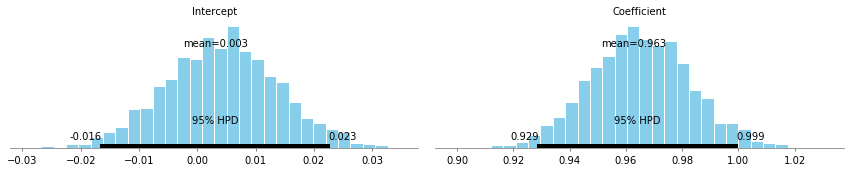

In [13]:
plots.plot_posterior(trace) ;

## 모수에 대한 사후 분포와 수렴여부를 시각화
* 수렴이 잘 됨을 확인 할 수 있다.

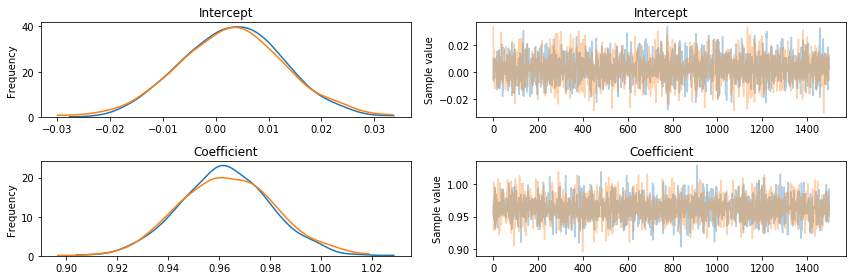

In [14]:
pm.traceplot(trace) ;